In [1]:
# 📦 STEP 1: Install required libraries (already pre-installed in Colab, but safe to include)
!pip install -q scikit-learn pandas

# 📁 STEP 2: Upload your two CSV files
from google.colab import files
uploaded = files.upload()

# 📊 STEP 3: Load the uploaded files into DataFrames
import pandas as pd

df_list = []
for filename in uploaded.keys():
    df = pd.read_csv(filename)
    df_list.append(df)

# Combine the datasets
df = pd.concat(df_list, ignore_index=True)

# 🛠 STEP 4: Replace driving duration with duration_in_traffic (when available)
df.loc[df["mode"] == "driving", "duration_seconds"] = df.loc[df["mode"] == "driving", "duration_in_traffic"]
df = df.dropna(subset=["duration_seconds"])

# 🔁 STEP 5: Pivot the table to align all modes per route/time
pivot = df.pivot_table(
    index=["day", "time", "timestamp", "origin_place", "origin_lat", "origin_lng",
           "destination_place", "destination_lat", "destination_lng"],
    columns="mode",
    values="duration_seconds"
).reset_index()

# Drop rows with any missing mode duration
pivot = pivot.dropna(subset=["driving", "transit", "walking", "bicycling"])

# 🏷 STEP 6: Determine the best mode (lowest duration)
pivot["best_mode"] = pivot[["driving", "transit", "walking", "bicycling"]].idxmin(axis=1)

# 🧠 STEP 7: Prepare features and labels
features = pivot[[
    "origin_lat", "origin_lng", "destination_lat", "destination_lng", "timestamp"
]]
labels = pivot["best_mode"]

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Encode string labels into numbers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.25, random_state=42)

# 🏋️ STEP 8: Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 📈 STEP 9: Evaluate the model
y_pred = clf.predict(X_test)
print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("🔢 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Saving enriched_routes_sn_to_wp_with_daytime.csv to enriched_routes_sn_to_wp_with_daytime.csv
Saving enriched_routes_wp_to_st_with_daytime.csv to enriched_routes_wp_to_st_with_daytime.csv
📋 Classification Report:

              precision    recall  f1-score   support

   bicycling       0.88      0.96      0.92        24
     driving       0.79      0.79      0.79        14
     transit       1.00      0.91      0.95        22

    accuracy                           0.90        60
   macro avg       0.89      0.88      0.89        60
weighted avg       0.90      0.90      0.90        60

🔢 Confusion Matrix:
[[23  1  0]
 [ 3 11  0]
 [ 0  2 20]]


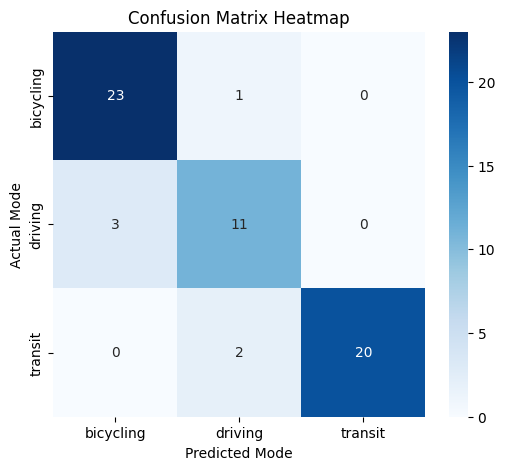

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the confusion matrix again
cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

# Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Mode")
plt.ylabel("Actual Mode")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# ✅ Prepare regression models for each mode
modes = ["driving", "transit", "walking", "bicycling"]
regressors = {}
metrics = {}

for mode in modes:
    # Filter data for this mode
    mode_df = df[df["mode"] == mode].copy()

    # Use duration_in_traffic for driving
    if mode == "driving":
        mode_df["duration"] = mode_df["duration_in_traffic"]
    else:
        mode_df["duration"] = mode_df["duration_seconds"]

    # Drop rows with missing durations
    mode_df = mode_df.dropna(subset=["duration"])

    # Feature set and target
    X = mode_df[["origin_lat", "origin_lng", "destination_lat", "destination_lng", "timestamp"]]
    y = mode_df["duration"]

    # Train/test split (75/25)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Store model and metrics
    regressors[mode] = model
    metrics[mode] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R²": r2_score(y_test, y_pred)
    }

# 📊 Show performance
for mode in modes:
    print(f"\nMode: {mode.upper()}")
    for metric, value in metrics[mode].items():
        print(f"{metric}: {value:.2f}")



Mode: DRIVING
MAE: 41.95
RMSE: 69.21
R²: 0.66

Mode: TRANSIT
MAE: 35.90
RMSE: 62.58
R²: 0.92

Mode: WALKING
MAE: 0.00
RMSE: 0.00
R²: 1.00

Mode: BICYCLING
MAE: 0.00
RMSE: 0.00
R²: 1.00


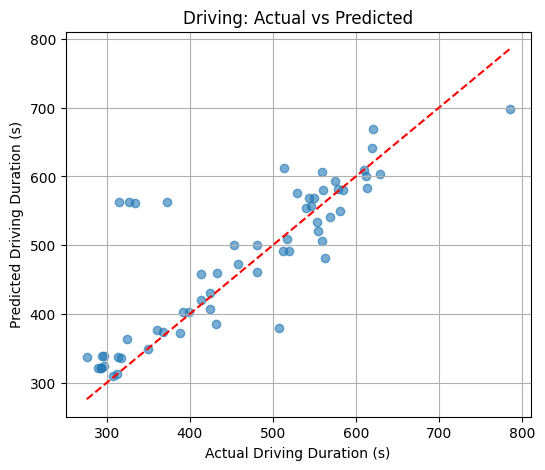

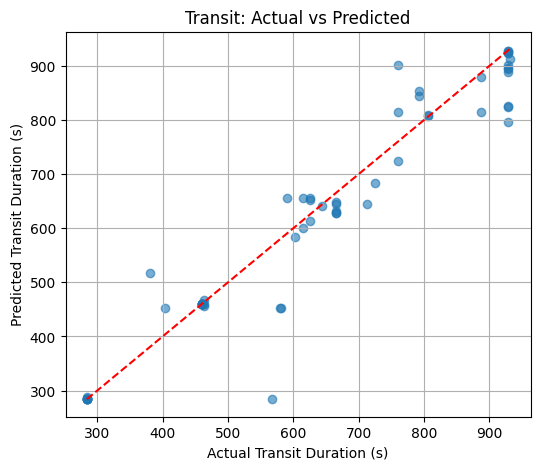

In [6]:
import matplotlib.pyplot as plt

# === Driving Plot ===
# Filter and prepare driving data
driving_df = df[df["mode"] == "driving"].copy()
driving_df["duration"] = driving_df["duration_in_traffic"]
driving_df = driving_df.dropna(subset=["duration"])
X_drive = driving_df[["origin_lat", "origin_lng", "destination_lat", "destination_lng", "timestamp"]]
y_drive = driving_df["duration"]
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_drive, y_drive, test_size=0.25, random_state=42)
y_pred_d = regressors["driving"].predict(X_test_d)

plt.figure(figsize=(6, 5))
plt.scatter(y_test_d, y_pred_d, alpha=0.6)
plt.plot([y_test_d.min(), y_test_d.max()], [y_test_d.min(), y_test_d.max()], 'r--')
plt.xlabel("Actual Driving Duration (s)")
plt.ylabel("Predicted Driving Duration (s)")
plt.title("Driving: Actual vs Predicted")
plt.grid(True)
plt.show()

# === Transit Plot ===
transit_df = df[df["mode"] == "transit"].copy()
transit_df["duration"] = transit_df["duration_seconds"]
X_transit = transit_df[["origin_lat", "origin_lng", "destination_lat", "destination_lng", "timestamp"]]
y_transit = transit_df["duration"]
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_transit, y_transit, test_size=0.25, random_state=42)
y_pred_t = regressors["transit"].predict(X_test_t)

plt.figure(figsize=(6, 5))
plt.scatter(y_test_t, y_pred_t, alpha=0.6)
plt.plot([y_test_t.min(), y_test_t.max()], [y_test_t.min(), y_test_t.max()], 'r--')
plt.xlabel("Actual Transit Duration (s)")
plt.ylabel("Predicted Transit Duration (s)")
plt.title("Transit: Actual vs Predicted")
plt.grid(True)
plt.show()
